### Project parameters

In [1]:
# Imports
import numpy as np
from keras.datasets import mnist
from keras import layers, optimizers, Model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display, SVG
import matplotlib.pyplot as plt
%matplotlib inline

# Data
(x_train, y_train), (_, _) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5 # Rescale -1 to 1
x_train = np.expand_dims(x_train, axis=3)

y_train = y_train.reshape(-1, 1)

history = [[],[],[],[]]

# Constants
img_rows, img_cols, img_chan = 28, 28, 1
img_shape = (img_rows, img_cols, img_chan)
num_classes = 10

# Hyperparameters
epochs = 22000
latent_dim = 200
batch_size = 32
half_batch_size = int(batch_size / 2)
genrtr_optimizer = optimizers.Adam(lr=0.0002,     # lr default:         0.001
                                   beta_1=0.5,    # beta_1 default:     0.9
                                   beta_2=0.999,
                                   epsilon=None, 
                                   decay=0.0, 
                                   amsgrad=False)
discrm_optimizer = genrtr_optimizer
combnd_optimizer = discrm_optimizer

print("Matrix Shapes:")
print('x_train:\t', x_train.shape)
print('y_train:\t', y_train.shape)
print("img shape:\t", img_shape)

Using TensorFlow backend.


Matrix Shapes:
x_train:	 (60000, 28, 28, 1)
y_train:	 (60000, 1)
img shape:	 (28, 28, 1)


### Generator model

In [2]:
# Input Layers: 2 layers: noise, class_labels
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,), dtype='int32')

# Create an embedding
label_embedding = layers.Embedding(num_classes, latent_dim)(label)
label_embedding = layers.Flatten()(label_embedding)

genrtr_input = layers.multiply([noise, label_embedding])

# Generator hidden layers
genrtr_hidden = layers.Dense(128 * 7 * 7, activation='relu', input_dim=latent_dim)(genrtr_input)
genrtr_hidden = layers.Reshape((7, 7, 128))(genrtr_hidden)
genrtr_hidden = layers.BatchNormalization(momentum=0.8)(genrtr_hidden)
genrtr_hidden = layers.UpSampling2D()(genrtr_hidden)
genrtr_hidden = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(genrtr_hidden)
genrtr_hidden = layers.BatchNormalization(momentum=0.8)(genrtr_hidden)
genrtr_hidden = layers.UpSampling2D()(genrtr_hidden)
genrtr_hidden = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(genrtr_hidden)
genrtr_hidden = layers.BatchNormalization(momentum=0.8)(genrtr_hidden)

generated_image = layers.Conv2D(img_chan, kernel_size=3, padding='same', activation='tanh')(genrtr_hidden)

# Finalize the model
generator = Model([noise, label], generated_image)
generator.compile(loss=['binary_crossentropy'], optimizer=genrtr_optimizer)

### Discriminator model

In [3]:
d_image = layers.Input(shape=img_shape)

discrm_hidden = layers.Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding='same')(d_image)
discrm_hidden = layers.LeakyReLU(alpha=0.2)(discrm_hidden)
discrm_hidden = layers.Dropout(0.25)(discrm_hidden)

discrm_hidden = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(discrm_hidden)
discrm_hidden = layers.ZeroPadding2D(padding=((0,1),(0,1)))(discrm_hidden)
discrm_hidden = layers.LeakyReLU(alpha=0.2)(discrm_hidden)
discrm_hidden = layers.Dropout(0.25)(discrm_hidden)
discrm_hidden = layers.BatchNormalization(momentum=0.8)(discrm_hidden)

discrm_hidden = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(discrm_hidden)
discrm_hidden = layers.LeakyReLU(alpha=0.2)(discrm_hidden)
discrm_hidden = layers.Dropout(0.25)(discrm_hidden)
discrm_hidden = layers.BatchNormalization(momentum=0.8)(discrm_hidden)

discrm_hidden = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(discrm_hidden)
discrm_hidden = layers.LeakyReLU(alpha=0.2)(discrm_hidden)
discrm_hidden = layers.Dropout(0.25)(discrm_hidden)
discrm_hidden = layers.Flatten()(discrm_hidden)

target_valid = layers.Dense(1, activation='sigmoid')(discrm_hidden)
target_label = layers.Dense(num_classes+1, activation='softmax')(discrm_hidden)

discriminator = Model(d_image, [target_valid, target_label])
discriminator.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'], 
                      optimizer=discrm_optimizer, 
                      metrics=['accuracy'])

# Don't update discriminator during generator training (moving target problem)
discriminator.trainable = False

# Don't recompile the discriminator so may still be trained independently...
target_valid, target_label = discriminator(generated_image)

### Combined model

In [4]:
# Combined model takes generator inputs and has discriminator outputs...
combined = Model([noise, label], [target_valid, target_label])
combined.compile(loss=['binary_crossentropy','sparse_categorical_crossentropy'], 
                 optimizer=combnd_optimizer)

### Model details

In [5]:
# SVG(model_to_dot(generator).create(prog='dot', format='svg'))
# SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))
# SVG(model_to_dot(combined).create(prog='dot', format='svg'))

# generator.summary()
# discriminator.summary()
# combined.summary()

In [ ]:
for epoch in range(epochs):

    idx = np.random.randint(0, x_train.shape[0], half_batch_size)
    real_images = x_train[idx]
    image_labels = y_train[idx]

    # Generated images
    input_noise = np.random.normal(0, 1, (half_batch_size, latent_dim))
    input_labels = np.random.randint(0, 10, half_batch_size).reshape(-1, 1)
    generated_images = generator.predict([input_noise, input_labels])
    
    valid = np.ones((half_batch_size, 1)) # 1.0 real
    fake = np.zeros((half_batch_size, 1)) # 0.0 fake
    
    # Assign the fake images to the "extra class" or "fake class"
    # on the one-hot encoding for all fake images (they are
    # not any of the digits 0-9 since they are -fakes- so
    # we don't used the requested generator labels...)
    fake_labels = 10 * np.ones(half_batch_size).reshape(-1, 1)
    
    d_loss_real = discriminator.train_on_batch(real_images, [valid, image_labels])
    d_loss_fake = discriminator.train_on_batch(generated_images, [fake, fake_labels])

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Training the generator...
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    # Note that we are using the combined model to backprop the loss to the generator... 
    valid = np.ones((batch_size, 1))
    # Give them some labels so the generator can learn which digit
    # it is trying to fake.
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
    
    # Train the generator
    g_loss = combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

    history[0] += [d_loss[0]]
    history[1] += [d_loss[3]]
    history[2] += [d_loss[4]]
    history[3] += [g_loss[0]]
    
    # Print progress indicator
    print("\r%d [Discriminator Loss: %f, Real/Fake-Acc.: %.2f%%, Classification-Acc: %.2f%%] [Generator Loss: %f]" % 
          (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]), end='')       

/home/mike/Anaconda3/envs/NeuralNets/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


136 [Discriminator Loss: 0.546162, Real/Fake-Acc.: 100.00%, Classification-Acc: 90.62%] [Generator Loss: 7.916899]

### Plot training history

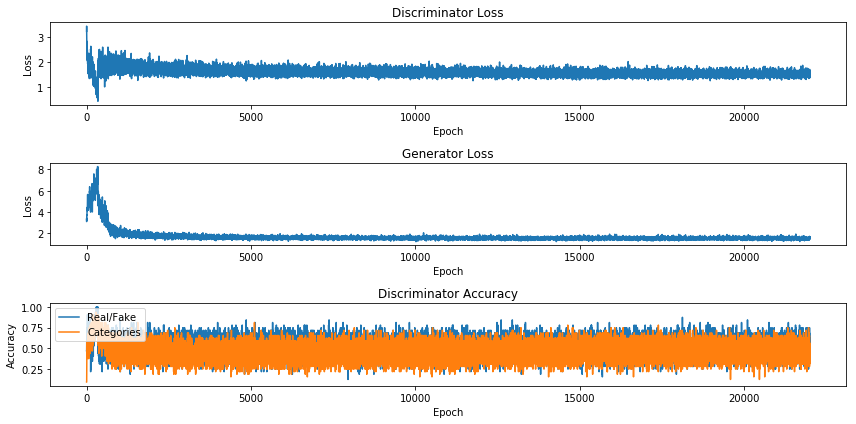

In [7]:
plt.figure(1,figsize=(12,6))

plt.subplot(311)
plt.plot(history[0])
plt.title('Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(312)
plt.plot(history[3])
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(313)
plt.plot(history[1])
plt.plot(history[2])
plt.title('Discriminator Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Real/Fake', 'Categories'], loc='upper left')
plt.tight_layout()
plt.show()

### Digit generation

In [ ]:
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, latent_dim))
sampled_labels = np.array([num for _ in range(r) for num in range(c)])

generated_images = generator.predict([noise, sampled_labels])
generated_images = 0.5 * generated_images + 1

fig, axs = plt.subplots(r, c)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(generated_images[count, :,:,0], cmap='binary')
        axs[i,j].axis('off')
        count += 1
plt.show()